### Python 机器学习实战（Scikit-Learn 0.23 / Keras 2.3 / TensorFlow 2.2）
## <center>1 >>> 加州房地产投资决策：房价预测</center>
### <center>算法验证：张君颖  ； 报告日期：2021.1.31</center>
  <font color=blue><center>作者邮箱：zhang.jun.ying@outlook.com</center></font>   
  
  <font color=blue><center>项目源代码、数据、自定义函数已上传GitHub：</center></font>   
    
<font color=blue><center>https://github.com/lotbear/Python-Financial-investment-strategy</center></font>

### 加州房地产投资决策 >>> 数据描述

本次任务为：利用加州人口普查数据，建立加州房价模型。   

数据中有许多指标，如每个街区的人口数量、收入中位数、房价中位数等。街区是美国人口普查局发布样本数量最小的地理单位（一个街区通常人口数为 600 人至 3000 人）。

数据来源：https://raw.githubusercontent.com/ageron/handson-ml2/master/   

#### <font color=blue>>>> 通过多指标</font> <font color=red> " 回归算法 "</font> <font color=blue>，预测加州任意区域的 </font><font color=red>" 房价中位数 "</font>       

数据基本情况：   

数据总量：20640 条数据，变量数：10个，包含 1 个目标值（房价中位数：median_house_value）   

其中，" 距离海洋位置（ocean_proximity）" 为离散型字符串变量，有 5 个取值且不可排序，后续建模需要进行数值编码。  

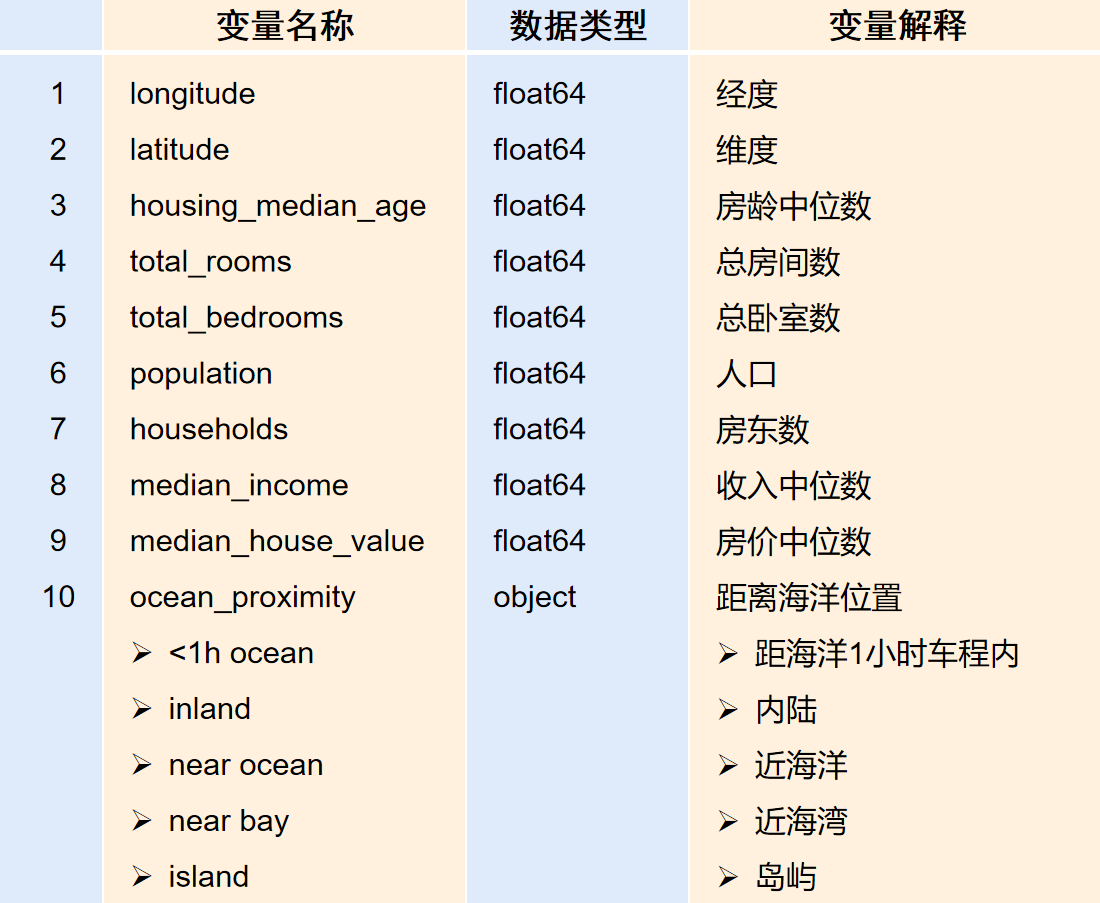

### >>> 数据建模
### 第一步：导入需要的 python 库

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings 
import warnings
warnings.filterwarnings("ignore")

### 第二步：获取数据，查看并观察 数据整体情况

In [2]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing") 
HOUSING_URL = DOWNLOAD_ROOT+"datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
# fetch_housing_data()

In [4]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
housing = load_housing_data()
print('查看数据最后 5 行：')
housing.tail()

查看数据最后 5 行：


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND
20639,-121.24,39.37,16.0,2785.0,616.0,1387.0,530.0,2.3886,89400.0,INLAND


In [6]:
print('查看数据整体信息：')
housing.info()

查看数据整体信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


观察以上数据信息，我们发现 " total_bedrooms " 变量存在缺失值，其余数据完整   

另外，" ocean_proximity " 为非数值型数据，后续需要进行数值编码

### >>> 三种查看离散数据取值类别（unique）的方法

In [7]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
set(housing["ocean_proximity"])

{'<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'}

In [9]:
np.unique(housing.ocean_proximity)

array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)

### >>> 查看变量直方图，发现：房龄中位数、房价中位数被设置上限
从 " median_house_age "、" median_house_value " 这两个变量直方图的最后一个 bin 可以看出，高于上限的数据都累计统计到最后的 bin 中，所以该区间数值异常高。   

这种上限设置是否会对数据建模产生不良影响，需要进行判断并进行数据处理。

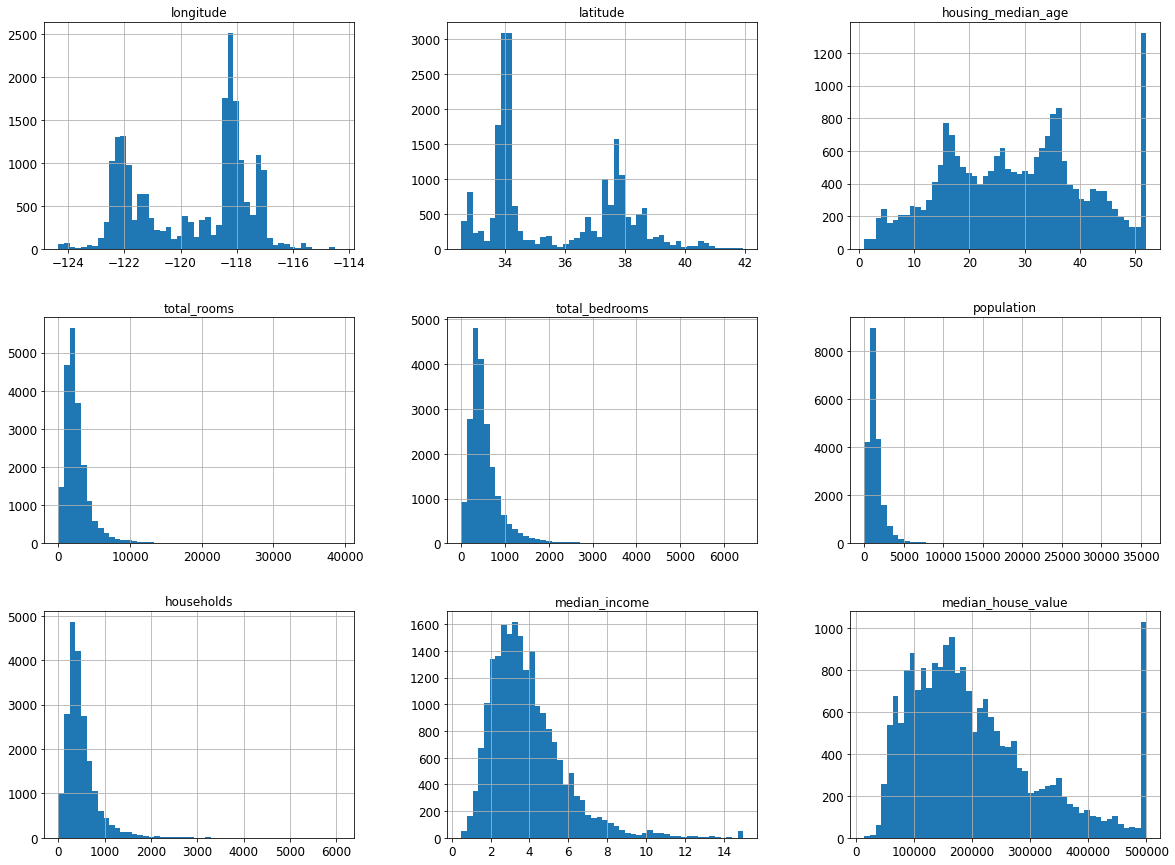

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15)) # 每个直方图分成50个直方条
plt.show()

### 数据准备

对于分布过于密集的数据，可以进行幂 ^n 运算，来分散数据   

对于过于分散的数据（尤其是右侧重尾数据），可以用对数运算 Log ,让数据呈现正态/钟型分布   

### >>> 从数据探索 + 可视化中获得洞见

<font color=blue>散点图体现多维数据信息:</font>   
    
1> 房子的经纬度地理位置；    

2> 区域房子数量累计（颜色深浅度叠加）   

3> 区域人口多少（圆圈大小）；    

4> 区域房价中位数（不同颜色）

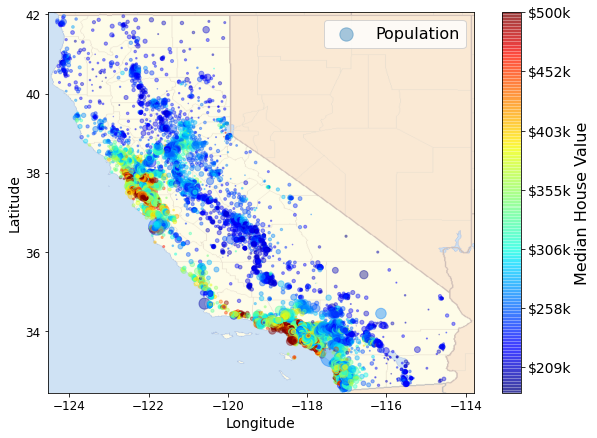

In [11]:
import matplotlib.image as mpimg
images_path = os.path.join( ".","images","1.加州房地产投资决策")
filename = "california.png"

california_img=mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
plt.show()

### >>> 寻找变量之间的相关性

In [12]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AD63E7B320>,
      dtype=object)

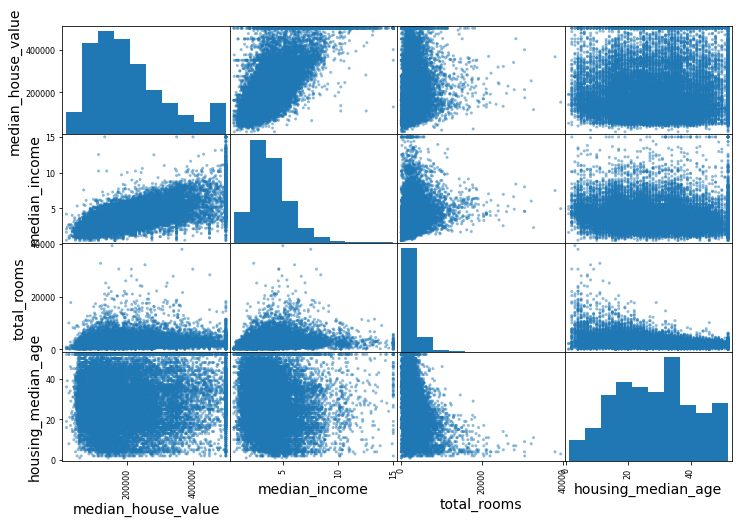

In [13]:
# 查看 两两变量相关性 散点图
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

(0.0, 16.0, 0.0, 550000.0)

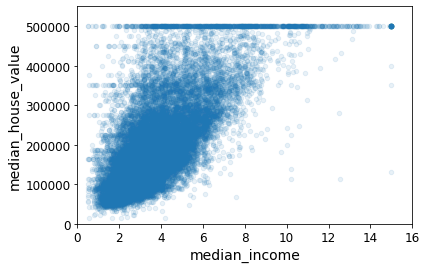

In [14]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])

从以上相关性散点图可以看出：收入中位数 media_income 与 房价中位数 median_house_value 具有较明显的相关性    

但也可以发现，纵轴 50W 美元房价处有一条清晰的水平线；在 45W 、 35W 、28W 美元处也有几条隐约的直线。   

这些直线可能是统计数据的过程中，存在的一些采集问题，为避免模型受这些异常数据影响，我们可以考虑删除这些区域的数据。

### 第三步：数据挖掘（特征工程）
对已有数据维度进行挖掘，创建三组新的数据列：   

rooms_per_household ==》每个家庭有几间房   

rooms_per_bedroom ==》每个卧室对应几个房间  

population_per_household ==》每个家庭有几个人   

In [15]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["rooms_per_bedroom"] = housing["total_rooms"]/housing["total_bedrooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [16]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_bedroom           0.383920
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
Name: median_house_value, dtype: float64

从上面的 房价相关性指标来看:  

每个卧室对应几个房间 rooms_per_bedroom 和 房间中位数 median_house_value 的相关系数为 0.379；   

正相关度较为明显，这个数据的特征提取是成功的。

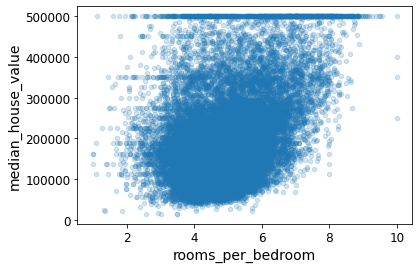

In [17]:
housing.plot(kind="scatter", x="rooms_per_bedroom", y="median_house_value",alpha=0.2)
plt.show()

### >>> 处理数据缺失值的三种方法：   

1> 放弃相应区域 housing.dropna(subset=['total_bedrooms'])   

2> 放弃整个属性 housing.drop( 'total_bedrooms',axis=1)   

3> 将缺失值设为某个值 housing['total_bedrooms'].fillna(median,inplace=True)

In [18]:
print('查看含有缺失数据的前 5 行：')
housing[housing.isnull().any(axis=1)].head()

查看含有缺失数据的前 5 行：


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,rooms_per_bedroom,population_per_household
290,-122.16,37.77,47.0,1256.0,NaN,570.0,218.0,4.3750,161900.0,NEAR BAY,5.761468,NaN,2.614679
341,-122.17,37.75,38.0,992.0,NaN,732.0,259.0,1.6196,85100.0,NEAR BAY,3.830116,NaN,2.826255
538,-122.28,37.78,29.0,5154.0,NaN,3741.0,1273.0,2.5762,173400.0,NEAR BAY,4.048704,NaN,2.938727
563,-122.24,37.75,45.0,891.0,NaN,384.0,146.0,4.9489,247100.0,NEAR BAY,6.102740,NaN,2.630137
696,-122.10,37.69,41.0,746.0,NaN,387.0,161.0,3.9063,178400.0,NEAR BAY,4.633540,NaN,2.403727


本例选择放弃相应区域，而非填充中位数，以下是 sklearn.impute 以中位数填充数据的代码：

In [19]:
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy="median")
# 
# # 删除 字符型数据，因为取中位数 median 的策略只能对数值型数据有效。
# housing_num = housing.drop("ocean_proximity", axis=1)
# # alternatively: housing_num = housing.select_dtypes(include=[np.number])
# 
# imputer.fit(housing_num)
# print('imputer.statistics_','\n','housing_num.median().values')
# 
# # 转换测试集数据：
# X = imputer.transform(housing_num)
# print(type(X))
# 
# # 转换后的数据 X 是 Numpy 的数组 array 格式，还需转换成 DataFrame 格式
# housing_tr = pd.DataFrame(X, columns=housing_num.columns,
#                           index=housing.index)
# print(housing_tr.loc[sample_incomplete_rows.index.values])

In [20]:
housing=housing.dropna(subset=['total_bedrooms'])

### >>> 离散型数据编码（将文本数据 => 数值型数据）

In [21]:
housing["ocean_proximity"].value_counts()
ocean_proximity_encoder = housing[["ocean_proximity"]]

方法一：顺序编码    

缺点：当类别数据之间不存在等距排序问题，顺序编码并不适用

In [22]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
ocean_ordinal_encoder = ordinal_encoder.fit_transform(ocean_proximity_encoder) # fit & transform
np.unique(ocean_ordinal_encoder)

array([0., 1., 2., 3., 4.])

In [23]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

方法二：one-hot 编码（本例采用）   

缺点：如果类别很多，one-hot 编码会占用太多空间，降低训练性能

In [24]:
from sklearn.preprocessing import OneHotEncoder

OneHot_encoder = OneHotEncoder()
ocean_OneHot_encoder = OneHot_encoder.fit_transform(ocean_proximity_encoder)
ocean_OneHot_encoder.toarray()

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [25]:
# 删除文本数据 ocean_proximity
housing_01=housing.drop(columns=['ocean_proximity','median_house_value'],axis=1)

### >>> 特征缩放，对数据进行标准化处理
以 total_rooms 变量为例，其最大值为 39320，最小值为 2；  

而 median_income 收入中位数的最大值为 15，最小值为 0.5；   

为减少数值属性的较大差异，影响模型训练性能，我们将数值进行标准化（数值减去均值，再除以标准差）。

In [26]:
housing_01.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,rooms_per_bedroom,population_per_household
count,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000
mean,-119.570689,35.633221,28.633094,2636.504233,537.870553,1424.946949,499.433465,3.871162,5.431344,4.984829,3.071533
std,2.003578,2.136348,12.591805,2185.269567,421.385070,1133.208490,382.299226,1.899291,2.482946,1.171676,10.438269
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,0.846154,1.000000,0.692308
25%,-121.800000,33.930000,18.000000,1450.000000,296.000000,787.000000,280.000000,2.563700,4.441441,4.169782,2.429032
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.536500,5.230769,4.922170,2.817582
75%,-118.010000,37.720000,37.000000,3143.000000,647.000000,1722.000000,604.000000,4.744000,6.052381,5.700364,3.281513
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,141.909091,10.000000,1243.333333


In [27]:
from sklearn.preprocessing import StandardScaler
housing_02=StandardScaler().fit_transform(housing_01)
type(housing_02)

numpy.ndarray

In [28]:
housing_02=pd.DataFrame(housing_02,columns=list(housing_01))
housing_02.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,rooms_per_bedroom,population_per_household
0,-1.327314,1.051717,0.982163,-0.803813,-0.970325,-0.973320,-0.976833,2.345163,0.625395,1.567772,-0.049433
1,-1.322323,1.042355,-0.606210,2.042130,1.348276,0.861339,1.670373,2.332632,0.324942,1.223744,-0.092134
2,-1.332305,1.037674,1.855769,-0.535189,-0.825561,-0.819769,-0.843427,1.782939,1.150594,2.335364,-0.025797
3,-1.337296,1.037674,1.855769,-0.623510,-0.718768,-0.765056,-0.733562,0.932970,0.155467,0.372508,-0.050162
4,-1.337296,1.037674,1.855769,-0.461970,-0.611974,-0.758879,-0.628930,-0.013143,0.342549,0.704892,-0.085272


In [29]:
OneHot_encoder=pd.DataFrame(ocean_OneHot_encoder.toarray(),columns=['OneHot_encoder_1',
                                                     'OneHot_encoder_2',
                                                     'OneHot_encoder_3',
                                                     'OneHot_encoder_4',
                                                     'OneHot_encoder_5'])
OneHot_encoder.head()

,OneHot_encoder_1,OneHot_encoder_2,OneHot_encoder_3,OneHot_encoder_4,OneHot_encoder_5
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0


In [30]:
target_column=pd.DataFrame(housing['median_house_value'],columns=['median_house_value']).reset_index(drop=True)

In [31]:
housing_03=pd.concat([housing_02,OneHot_encoder,target_column],axis=1)
housing_03.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20433 entries, 0 to 20432
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 20433 non-null  float64
 1   latitude                  20433 non-null  float64
 2   housing_median_age        20433 non-null  float64
 3   total_rooms               20433 non-null  float64
 4   total_bedrooms            20433 non-null  float64
 5   population                20433 non-null  float64
 6   households                20433 non-null  float64
 7   median_income             20433 non-null  float64
 8   rooms_per_household       20433 non-null  float64
 9   rooms_per_bedroom         20433 non-null  float64
 10  population_per_household  20433 non-null  float64
 11  OneHot_encoder_1          20433 non-null  float64
 12  OneHot_encoder_2          20433 non-null  float64
 13  OneHot_encoder_3          20433 non-null  float64
 14  OneHot

### <font color=blue>数据名称变换汇总：</font>

housing 为原始数据，删除缺失值，并新增 3 个特征变量   

housing_01 基于 housing 删除了文本数据["ocean_proximity"] 和目标数据["median_house_value"]   

housing_02 基于 housing_01 进行标准化处理后的数据（数据减去该列均值，再除以标准差）    

OneHot_encoder 是 housing["ocean_proximity"] 离散型文本数据进行 one-hot 编码后的数据

housing_03 基于 housing_02 + OneHot_encoder + 目标数据["median_house_value"] 后的最终数据，可用于训练模型

### 第四步：创建训练集 / 测试集
### >>> 方法一：随机生成排列序号，用 seed(N) 固定，整体数据 split (20%) 给测试集

In [32]:
np.random.seed(16)

In [33]:
import numpy as np

# Sklearn 有 train_test_split() 函数可以调用，这里自定义只是为了解释说明
def split_train_test(data, test_ratio): 
    shuffled_indices = np.random.permutation(len(data)) # 将数据索引随机排列
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [34]:
train_set, test_set = split_train_test(housing_03, 0.2)
print('训练集数据量：',len(train_set))
print('测试集数据量：',len(test_set))

训练集数据量： 16347
测试集数据量： 4086


### >>> 方法二：计算每个实例标识的哈希值，若哈希值小于最大哈希值的 20% 则放入测试集

该方法的好处是，当整个数据集更新时，重新 split 的测试集不会夹杂此前训练集中的数据（防止数据窥探偏误），而新增数据的 20% 会加入到测试集

In [35]:
import hashlib

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [36]:
housing_with_id = housing_03.reset_index()   # 增加一个 'index' 列
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,rooms_per_bedroom,population_per_household,OneHot_encoder_1,OneHot_encoder_2,OneHot_encoder_3,OneHot_encoder_4,OneHot_encoder_5,median_house_value
4,4,-1.337296,1.037674,1.855769,-0.461970,-0.611974,-0.758879,-0.628930,-0.013143,0.342549,0.704892,-0.085272,0.0,0.0,0.0,1.0,0.0,342200.0
5,5,-1.337296,1.037674,1.855769,-0.785965,-0.770978,-0.893015,-0.801574,0.087213,-0.269721,-0.572079,-0.089254,0.0,0.0,0.0,1.0,0.0,269700.0
11,11,-1.342287,1.037674,1.855769,0.396526,0.508169,0.069762,0.613583,-0.316263,-0.265362,-0.278739,-0.097958,0.0,0.0,0.0,1.0,0.0,241800.0
20,20,-1.347279,1.037674,0.902745,-0.862846,-0.839800,-0.896544,-0.872201,-1.323348,-0.365401,-0.770972,-0.058218,0.0,0.0,0.0,1.0,0.0,147500.0
23,23,-1.347279,1.032993,1.855769,-0.434055,-0.476703,-0.504727,-0.456286,-0.890123,-0.095654,0.020546,-0.042816,0.0,0.0,0.0,1.0,0.0,99700.0


In [37]:
print('训练集数据量：',len(train_set))
print('测试集数据量：',len(test_set))

训练集数据量： 16199
测试集数据量： 4234


### >>> 方法三：用房子所在地的经纬度，作为唯一标识，划分 20% 给测试集

In [38]:
housing_with_id["id"] = housing_03["longitude"] * 1000 + housing_03["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [39]:
test_set[['longitude','latitude','id']].head()

,longitude,latitude,id
1,-1.322323,1.042355,-1321.280202
3,-1.337296,1.037674,-1336.258463
4,-1.337296,1.037674,-1336.258463
5,-1.337296,1.037674,-1336.258463
6,-1.337296,1.032993,-1336.263144


直接调用 sklearn 的 train_test_split 函数（与方法一 相同）：

In [40]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing_03, test_size=0.2, random_state=42)

### 方法四：按比例分层抽样，得到测试集数据

前三个方法讨论的是纯随机抽样，实际操作中，<font color=blue>当数据量庞大，随机抽样得到的 " 测试集 " 会出现抽样偏差。</font>     

经验判断：房价中位数 和 收入中位数有重要关联，可以考虑用 收入中位数作为数据分层抽样的基准属性。   

由于收入中位数是连续型数值，我们需要进行 bin 分箱处理，再以其分布规律进行同比例抽样，最终得到测试集数据。

查看 “收入中位数” 直方图：


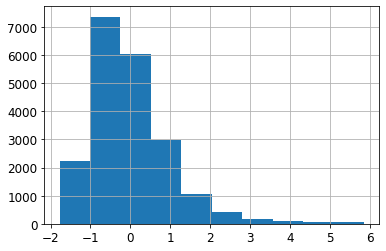

In [41]:
print('查看 “收入中位数” 直方图：')
housing_03["median_income"].hist()

In [42]:
# 收入中位数分箱
housing_03["income_cat"] = pd.cut(housing_03["median_income"],bins=5,labels=[1, 2, 3, 4, 5])
housing["income_cat"] = pd.cut(housing["median_income"],bins=5,labels=[1, 2, 3, 4, 5])

In [43]:
housing_03["income_cat"].value_counts()

1    9581
2    9001
3    1475
4     267
5     109
Name: income_cat, dtype: int64

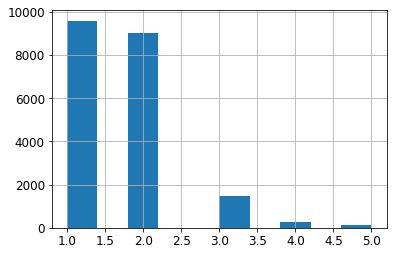

In [44]:
housing_03["income_cat"].hist()

In [45]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=16)
for train_index, test_index in split.split(housing_03, housing_03["income_cat"]):
    strat_train_set = housing_03.loc[train_index]
    strat_test_set = housing_03.loc[test_index]

### >>> 对比：基于收入分层，随机抽样和分层抽样得到的测试集

In [46]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing_03, test_size=0.2, random_state=16)

compare_props = pd.DataFrame({
    "总体样本": income_cat_proportions(housing_03),
    "分层抽样": income_cat_proportions(strat_test_set),
    "随机抽样": income_cat_proportions(test_set),
}).sort_index()
compare_props["随机抽样偏差 %"] = 100 * compare_props["随机抽样"] / compare_props["总体样本"] - 100
compare_props["分层抽样偏差 %"] = 100 * compare_props["分层抽样"] / compare_props["总体样本"] - 100

In [47]:
compare_props

,总体样本,分层抽样,随机抽样,随机抽样偏差 %,分层抽样偏差 %
1,0.468898,0.468804,0.467580,-0.281131,-0.020223
2,0.440513,0.440421,0.446782,1.423247,-0.020896
3,0.072187,0.072180,0.068999,-4.416135,-0.009787
4,0.013067,0.013213,0.011255,-13.866109,1.113698
5,0.005335,0.005383,0.005383,0.907554,0.907554


In [48]:
# 数据恢复原样，删除 " income_cat " 分层变量（仅对分层有用，对建模没有）
for set_ in (strat_train_set, strat_test_set, housing, housing_03):
    set_.drop("income_cat", axis=1, inplace=True)

### >>> 本例选择分层抽样创建 训练集 / 测试集

In [49]:
# 备份训练集数据，准备建模
train_set = strat_train_set.copy()

# 分离出 训练数据集中的目标数据 median_house_value
train_set_variables = train_set.drop("median_house_value", axis=1) 
train_set_labels = train_set["median_house_value"].copy()

In [50]:
test_set = strat_test_set.copy()
test_set_variables = test_set.drop("median_house_value", axis=1) 
test_set_labels = test_set["median_house_value"].copy()

### 第五步：选择训练数据的模型
### 1 >>>  线性回归模型 LinearRegression

In [51]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(train_set_variables, train_set_labels)

LinearRegression()

In [52]:
from sklearn.metrics import mean_squared_error

test_predictions = lin_reg.predict(test_set_variables)
lin_mse = mean_squared_error(test_set_labels, test_predictions)
lin_rmse = np.sqrt(lin_mse)
print('线性回归模型的 RMSE 误差值：',lin_rmse)

线性回归模型的 RMSE 误差值： 68373.27372604933


In [53]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(test_set_labels, test_predictions)
print('线性回归模型的 MAE 误差值：',lin_mae)

线性回归模型的 MAE 误差值： 49757.91323014736


### 2 >>>  决策树回归模型 DecisionTreeRegressor

In [54]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=16)
tree_reg.fit(train_set_variables, train_set_labels)

DecisionTreeRegressor(random_state=16)

In [55]:
test_predictions = tree_reg.predict(test_set_variables)
tree_mse = mean_squared_error(test_set_labels, test_predictions)
tree_rmse = np.sqrt(tree_mse)
print('决策树回归模型的 RMSE 误差值：',tree_rmse)

决策树回归模型的 RMSE 误差值： 71556.56502468266


### K --- 折交叉验证

In [56]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, train_set_variables, train_set_labels,
                         scoring="neg_mean_squared_error", cv=10) # 10 折交叉验证
tree_rmse_scores = np.sqrt(-scores)

In [57]:
def display_scores(scores):
    print('K=10 折交叉验证结果',"\n")
    print("RMSE 误差:","\n", scores,"\n")
    print("RMSE 均值:", scores.mean(),"\n")
    print("RMSE 标准差:", scores.std())

print('决策树回归模型')
display_scores(tree_rmse_scores)

决策树回归模型
K=10 折交叉验证结果 

RMSE 误差: 
 [73072.28289677 71687.44863326 68252.05527733 69702.3993474
 70529.48402256 69721.07877721 69764.97632384 66164.660054
 74318.22489109 70906.05326858] 

RMSE 均值: 70411.86634920284 

RMSE 标准差: 2198.2984519274128


In [58]:
lin_scores = cross_val_score(lin_reg, train_set_variables, train_set_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

print('线性回归模型')
display_scores(lin_rmse_scores)

线性回归模型
K=10 折交叉验证结果 

RMSE 误差: 
 [68018.13528412 67380.69692466 72365.09398574 67680.01916131
 64501.37535405 71325.99286547 68261.31345848 66255.52588726
 70641.03580497 68608.88225005] 

RMSE 均值: 68503.80709761058 

RMSE 标准差: 2253.041673798479


### 3 >>>  随机森林回归模型 RandomForestRegressor

In [59]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=16)
forest_reg.fit(train_set_variables, train_set_labels)

RandomForestRegressor(random_state=16)

In [60]:
test_predictions = forest_reg.predict(test_set_variables)
forest_mse = mean_squared_error(test_set_labels, test_predictions)
forest_rmse = np.sqrt(forest_mse)
print('随机森林回归模型的 RMSE 误差值：',forest_rmse)

随机森林回归模型的 RMSE 误差值： 50682.96034881303


In [61]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, train_set_variables, train_set_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

print('随机森林回归模型')
display_scores(forest_rmse_scores)

随机森林回归模型
K=10 折交叉验证结果 

RMSE 误差: 
 [49596.91865261 51140.3527315  48888.26971943 48105.34287422
 47896.87769887 51654.45123463 48982.54246697 48336.28411169
 51200.17976979 49651.49799147] 

RMSE 均值: 49545.27172511717 

RMSE 标准差: 1294.069493715421


### 4 >>>支持向量机 SVM 线性回归模型

In [62]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(train_set_variables, train_set_labels)
test_predictions = svm_reg.predict(test_set_variables)
svm_mse = mean_squared_error(test_set_labels, test_predictions)
svm_rmse = np.sqrt(svm_mse)
print('随机森林回归模型的 RMSE 误差值：',svm_rmse)

随机森林回归模型的 RMSE 误差值： 110105.78004905215


### 第六步：微调模型 --- 寻找最优参数
以随机森林为例，网格搜索最优超参数：   

n_estimators：森林中估计值的个数    

max_features ：寻找最佳分裂点时考虑的属性数目   

bootstrap ：是否采用有放回样本的方式 [True / False] 

In [63]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=16)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(train_set_variables, train_set_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=16),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

最优参数组合：

In [64]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30, random_state=16)

显示网格参数筛选过程中，每组超参数所对应的模型 RMSE 误差值

In [65]:
print('RMSE 误差值, 超参数{ 最佳分裂点考虑的属性数目, 参数数量 }','\n')
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

RMSE 误差值, 超参数{ 最佳分裂点考虑的属性数目, 参数数量 } 

63107.13502471242 {'max_features': 2, 'n_estimators': 3}
55383.268603273274 {'max_features': 2, 'n_estimators': 10}
52732.49937105589 {'max_features': 2, 'n_estimators': 30}
60418.42249073378 {'max_features': 4, 'n_estimators': 3}
52322.82295795301 {'max_features': 4, 'n_estimators': 10}
49980.17824762758 {'max_features': 4, 'n_estimators': 30}
59250.67536055676 {'max_features': 6, 'n_estimators': 3}
51482.283053034764 {'max_features': 6, 'n_estimators': 10}
49450.53671116928 {'max_features': 6, 'n_estimators': 30}
57211.33537147765 {'max_features': 8, 'n_estimators': 3}
51344.03013604134 {'max_features': 8, 'n_estimators': 10}
49608.00352661749 {'max_features': 8, 'n_estimators': 30}
60851.29444667389 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54405.37884151177 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59182.448244361934 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
51951.81137759966 {'bootstrap': Fal

随机搜索最优超参数：

In [66]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=16)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=16)
rnd_search.fit(train_set_variables, train_set_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=16),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001AD6399AF60>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001AD639AD860>},
                   random_state=16, scoring='neg_mean_squared_error')

In [67]:
print('RMSE 误差值, 超参数{ 最佳分裂点考虑的属性数目, 参数数量 }','\n')
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

RMSE 误差值, 超参数{ 最佳分裂点考虑的属性数目, 参数数量 } 

51402.51558876603 {'max_features': 2, 'n_estimators': 122}
48920.756023358445 {'max_features': 6, 'n_estimators': 66}
48942.91991890222 {'max_features': 4, 'n_estimators': 197}
48651.08108746384 {'max_features': 6, 'n_estimators': 160}
49337.776452900485 {'max_features': 5, 'n_estimators': 42}
54097.56347383064 {'max_features': 1, 'n_estimators': 145}
48752.08988300692 {'max_features': 7, 'n_estimators': 121}
49648.560937817245 {'max_features': 3, 'n_estimators': 111}
49657.23618391905 {'max_features': 3, 'n_estimators': 117}
54558.74177586164 {'max_features': 1, 'n_estimators': 66}


In [68]:
feature_importances = grid_search.best_estimator_.feature_importances_
attributes = list(test_set_variables)
print('各变量重要性排序：')
sorted(zip(feature_importances, attributes), reverse=True)

各变量重要性排序：


[(0.35814313958780014, 'median_income'),
 (0.14383025118844153, 'OneHot_encoder_2'),
 (0.10351872669174836, 'population_per_household'),
 (0.07943999422018158, 'longitude'),
 (0.06523564376072992, 'latitude'),
 (0.06314694339783244, 'rooms_per_bedroom'),
 (0.05393142565862579, 'rooms_per_household'),
 (0.04024214547972435, 'housing_median_age'),
 (0.018671088015921607, 'population'),
 (0.01794419447907597, 'OneHot_encoder_1'),
 (0.017160559337091576, 'total_bedrooms'),
 (0.016692468169649935, 'total_rooms'),
 (0.015093009658993654, 'households'),
 (0.004342115049258826, 'OneHot_encoder_5'),
 (0.0024560531699048898, 'OneHot_encoder_4'),
 (0.00015224213501960525, 'OneHot_encoder_3')]

### >>> 以最优超参数拟合 随机森林回归模型：

In [69]:
final_model = grid_search.best_estimator_
final_predictions = final_model.predict(test_set_variables)

### >>> <font color=red>测试集 真实房价中位数 PK 模型预测房价中位数</font>

In [70]:
true_data=pd.DataFrame(test_set_labels.values.round(1).reshape(-1,1),columns=['真实房价中位数'])
predict_data=pd.DataFrame(final_predictions.round(1).reshape(-1,1),columns=['预测房价中位数'])

In [71]:
truth_vs_prediction=pd.concat([true_data,predict_data],axis=1)
truth_vs_prediction

,真实房价中位数,预测房价中位数
0,138500.0,153366.7
1,287500.0,215993.3
2,226400.0,263746.7
3,219600.0,227060.0
4,130000.0,133543.3
...,...,...
4082,102100.0,127433.3
4083,59300.0,67466.7
4084,227400.0,252100.0
4085,339700.0,324020.0


In [72]:
final_mse = mean_squared_error(test_set_labels, final_predictions)
final_rmse = np.sqrt(final_mse)
print('最优随机森林回归模型的 RMSE 误差值：',final_rmse)

最优随机森林回归模型的 RMSE 误差值： 50092.9075096378


计算测试集 RMSE 泛化误差的 95% 置信区间

In [73]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - test_set_labels) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([47730.69470881, 52348.63463504])

### >>> 真实房价中位数 vs 预测房价中位数的分布情况

真实房价中位数 与 预测房价中位数的分布情况：


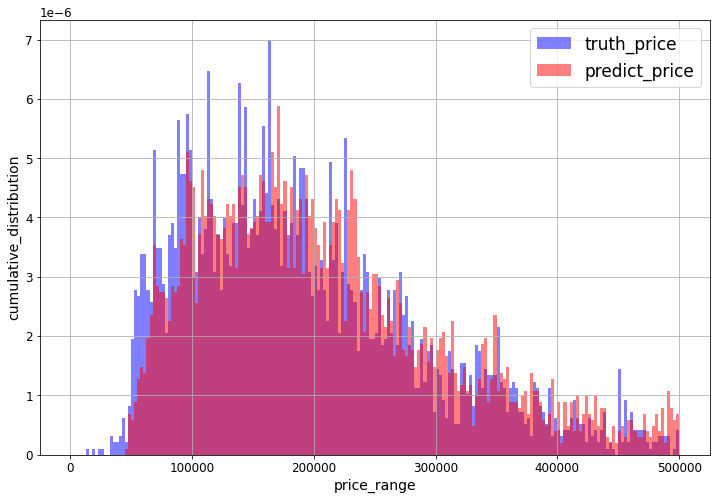

In [74]:
print('真实房价中位数 与 预测房价中位数的分布情况：')
plt.figure(figsize=(12,8))
truth_vs_prediction["真实房价中位数"].hist(bins=200,alpha=0.5,label="truth_price",
         color='blue',range=(0,499999),density=True,rwidth=0.3,histtype='stepfilled')
truth_vs_prediction["预测房价中位数"].hist(bins=200,alpha=0.5,label="predict_price",
         color='red',range=(0,499999),density=True,rwidth=0.3,histtype='stepfilled')

plt.xlabel('price_range')
plt.ylabel('cumulative_distribution')
plt.legend(fontsize=17)  
plt.show()